# Cats and Dogs from [CIFAR10](https://keras.io/datasets/)!

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

# getting the datset
from keras.datasets import cifar10
from keras import backend as K

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


** Load Cats and Dogs From CIFAR10 dataset **

First we load the CIFAR10 data and extract all cats and dogs from it.

170500096/170498071 [==============================] - 154s 1us/step
x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
channels_last


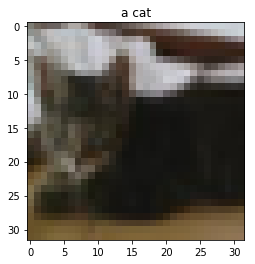

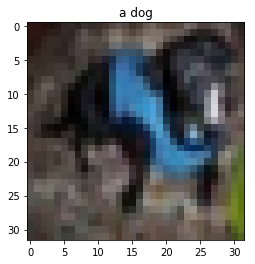

In [2]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Reduce to cats and dogs
def extract(x,y,labels):
    arg_train = []
    new_y = np.zeros(np.max(labels)+1)
    for i,l in enumerate(labels):
        arg_train.append(np.argwhere(y == l)[:,0])
        new_y[l] = i
    arg_train = np.concatenate(arg_train)
    return x[arg_train], new_y[y[arg_train]]
    
x_train, y_train = extract(x_train, y_train, [3,5])
x_test, y_test = extract(x_test, y_test, [3,5])

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

img_rows, img_cols, channels = x_train.shape[1:]

print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

plt.imshow(x_train[np.argmax(y_train==0)])
plt.title("a cat")
plt.show()
plt.imshow(x_train[np.argmax(y_train==1)])
plt.title("a dog")
plt.show()

Next, we just define a function which will display the results later.

In [16]:
def predict(idx, model, data, avg=None, norm=None, cols=5, threshold=.3):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    cats = 0
    dogs = 0
    data = data[idx]
    if norm is None:
        p = model.predict(data)
    else:
        p = model.predict(data/norm)
    i = 0
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax in axs:
            if avg is not None:
                img = (data[i]+avg)
            else:
                img = (data[i])

            ax.imshow(img)
            if p[i] < threshold:
                label = "cat"
                cats += 1
            elif p[i] > 1-threshold:
                label = "dog"
                dogs += 1
            else:
                label = "not sure"
            ax.text(.5,0, label+ "; score = " + str(p[i]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
        plt.show()
    print(cats, " cats (", cats/len(idx)*100., "%),", dogs, " dogs (", dogs/len(idx)*100., "%)")

In [17]:
batch_size = 128

# Convolutional Neural Network

A very simple CNN... (> 70% validation accuray after 10 epochs)

In [18]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.adam(lr=0.001) #keras.optimizers.Adadelta()

model1.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               3211520   
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
__________

We will train for ten epochs (iterations ofer the whole training data)...

In [19]:
model1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 213us/step - loss: 0.6714 - acc: 0.5889 - val_loss: 0.6254 - val_acc: 0.6490
Epoch 2/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.5996 - acc: 0.6793 - val_loss: 0.5740 - val_acc: 0.6925
Epoch 3/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.5578 - acc: 0.7131 - val_loss: 0.5500 - val_acc: 0.7170
Epoch 4/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.5117 - acc: 0.7433 - val_loss: 0.5328 - val_acc: 0.7210
Epoch 5/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.4824 - acc: 0.7664 - val_loss: 0.5388 - val_acc: 0.7360
Epoch 6/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.4273 - acc: 0.8008 - val_loss: 0.5402 - val_acc: 0.7300
Epoch 7/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.3815 - acc: 0.8251 - val_loss: 0.5867 - v

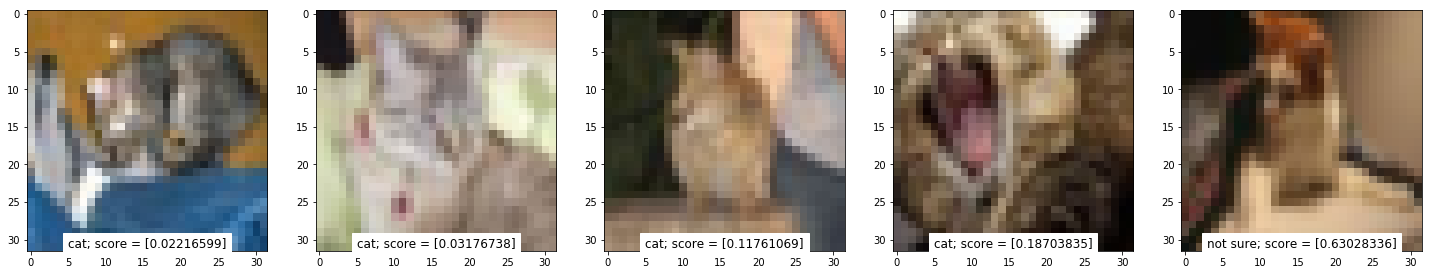

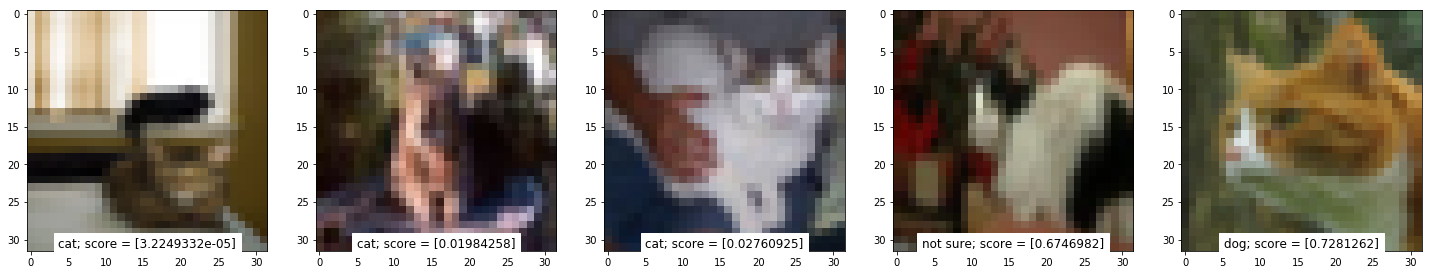

7  cats ( 70.0 %), 1  dogs ( 10.0 %)


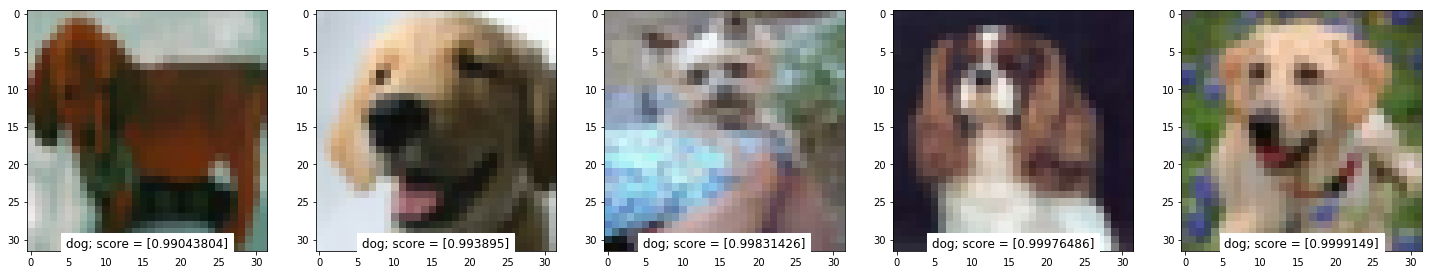

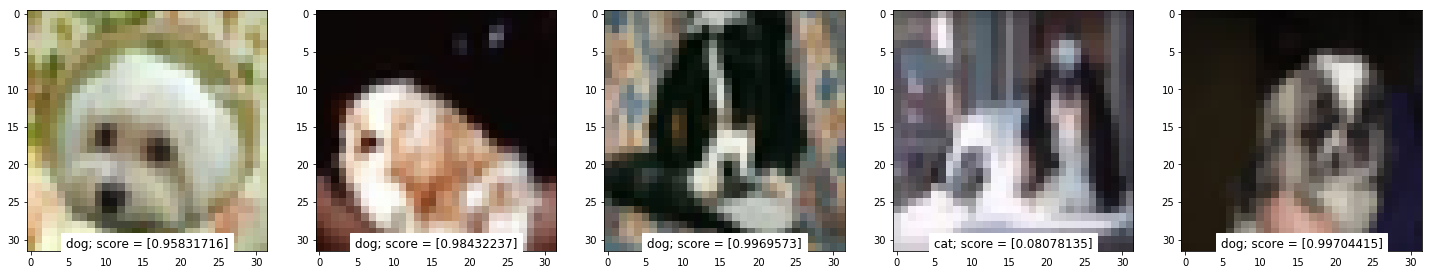

1  cats ( 10.0 %), 9  dogs ( 90.0 %)


In [20]:
predict(range(10), model1, x_test)
predict(range(x_test.shape[0]-10, x_test.shape[0]), model1, x_test)

A rather simple CNN: Deeper that the one above, but actually with fewer trainable parameters. It gives slightly better performance

In [21]:
model2 = Sequential()
model2.add(Conv2D(48, kernel_size=(5, 5), padding="same",
                 activation='relu', input_shape=input_shape))
model2.add(Conv2D(32, (5, 5), activation='relu', padding="same"))
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(96, (5, 5), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(160, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
model2.add(Flatten())
model2.add(Dropout(.3))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

opt = keras.optimizers.adam(lr=0.001)

model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 48)        3648      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        38432     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 96)        76896     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        55360     
__________

In [22]:
model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 4s 389us/step - loss: 0.7188 - acc: 0.5558 - val_loss: 0.7668 - val_acc: 0.5345
Epoch 2/10
10000/10000 [==============================] - 2s 215us/step - loss: 0.6636 - acc: 0.5922 - val_loss: 0.7040 - val_acc: 0.5120
Epoch 3/10
10000/10000 [==============================] - 2s 215us/step - loss: 0.6198 - acc: 0.6540 - val_loss: 0.6654 - val_acc: 0.5990
Epoch 4/10
10000/10000 [==============================] - 2s 215us/step - loss: 0.5765 - acc: 0.6929 - val_loss: 0.7862 - val_acc: 0.5670
Epoch 5/10
10000/10000 [==============================] - 2s 215us/step - loss: 0.5321 - acc: 0.7311 - val_loss: 0.8127 - val_acc: 0.5460
Epoch 6/10
10000/10000 [==============================] - 2s 215us/step - loss: 0.4919 - acc: 0.7607 - val_loss: 0.5520 - val_acc: 0.7085
Epoch 7/10
10000/10000 [==============================] - 2s 215us/step - loss: 0.4579 - acc: 0.7829 - val_loss: 0.6416 - v

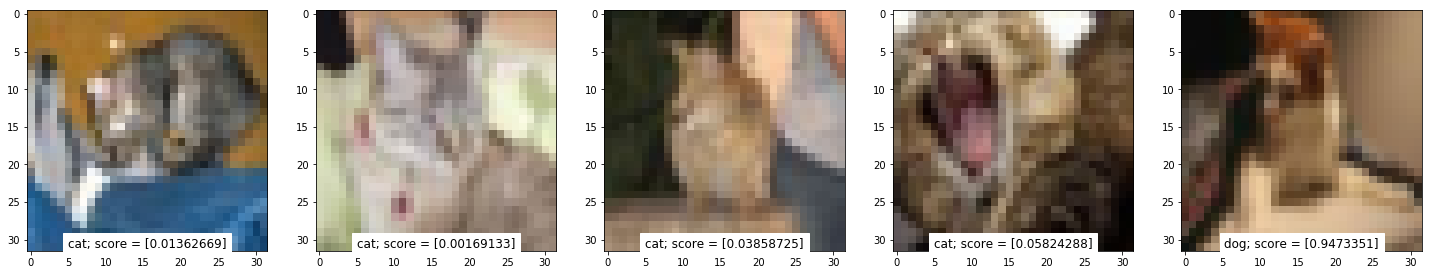

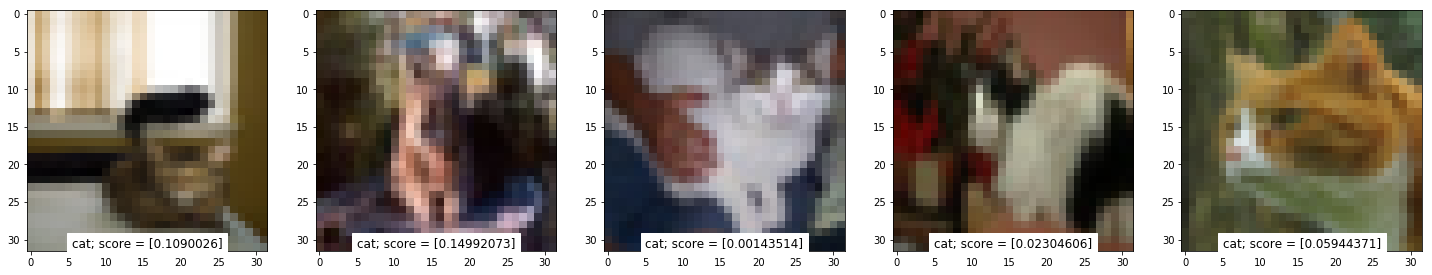

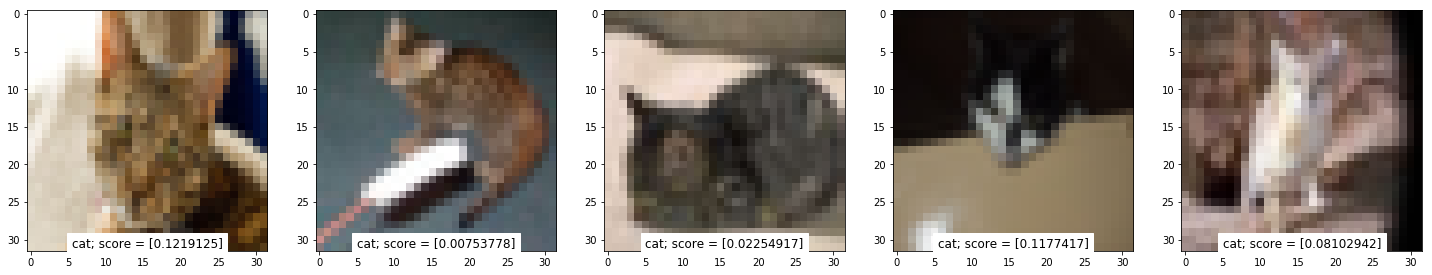

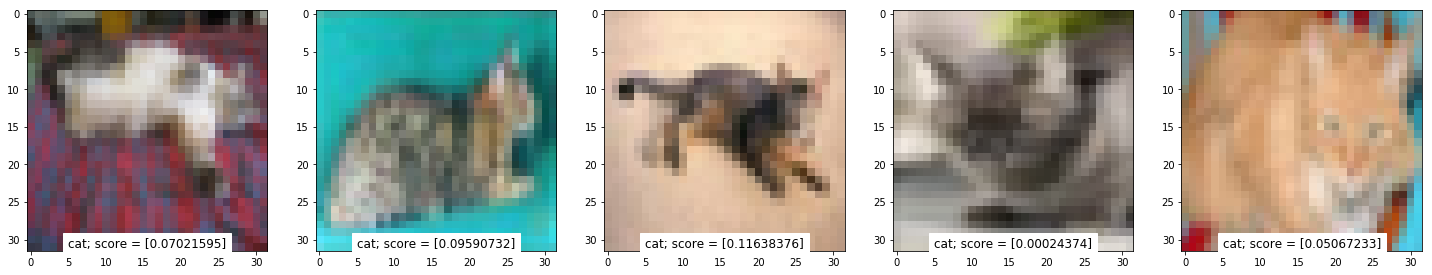

19  cats ( 95.0 %), 1  dogs ( 5.0 %)


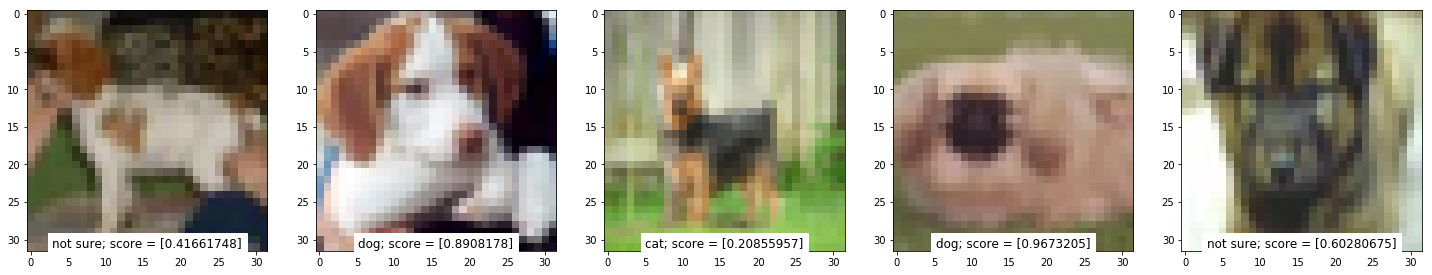

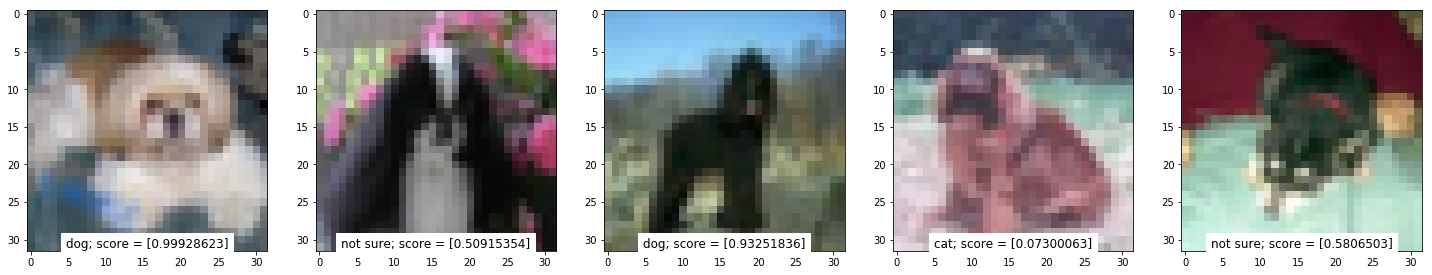

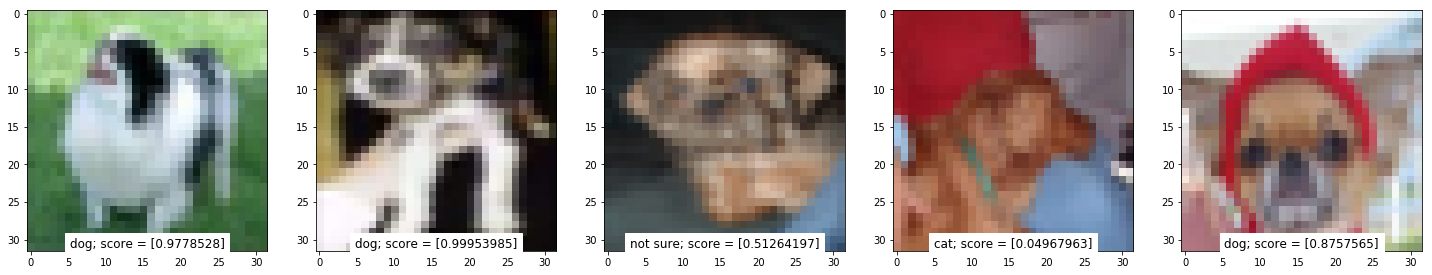

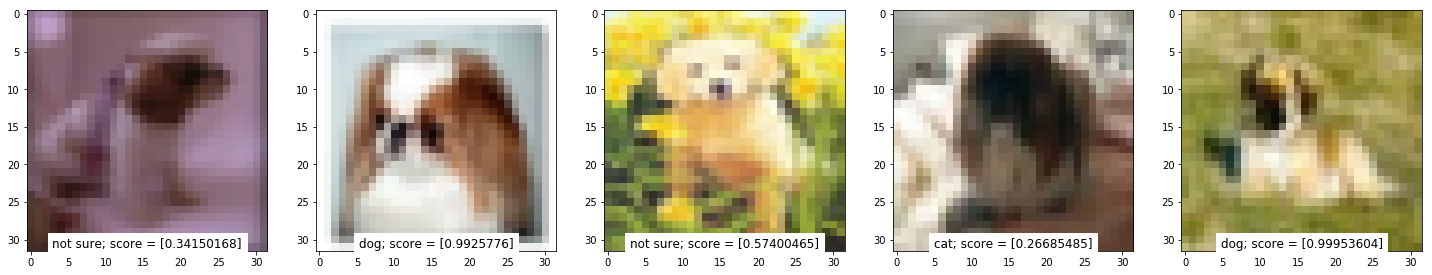

4  cats ( 20.0 %), 9  dogs ( 45.0 %)


In [23]:
predict(range(20), model2, x_test)
predict(range(x_test.shape[0]//2, x_test.shape[0]//2+20), model2, x_test)

## Data Augmentation

Looking at the training progress we can see, that in the end the loss decreases but the validation loss does not. The network is only optimized for the training data. The test data is used to validate the performance on unseen images. What we observe here is called overfitting. This problem will be adressed in depth in the session on regularization.

One simple explanation for the phenomenon in our case is, that we have limited training data over which we interate over and over and many parameters in our network which can *memorize* the data. One way to get more data is augmenting the available data with randomly transformed data which stil retains the same labels.

In [24]:
from keras.preprocessing.image import ImageDataGenerator

# traning data is augmented
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

With the augmented training data we can continue training and improve the results on the test set.

In [25]:
model2.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Epoch 1/50
15/15 [==============================] - 1s 60ms/step - loss: 0.4742 - acc: 0.7760 - val_loss: 0.5721 - val_acc: 0.6995
Epoch 2/50
15/15 [==============================] - 1s 50ms/step - loss: 0.4687 - acc: 0.7719 - val_loss: 0.4869 - val_acc: 0.7625
Epoch 3/50
15/15 [==============================] - 1s 47ms/step - loss: 0.4339 - acc: 0.7856 - val_loss: 0.4840 - val_acc: 0.7660
Epoch 4/50
15/15 [==============================] - 1s 50ms/step - loss: 0.4334 - acc: 0.7911 - val_loss: 0.4527 - val_acc: 0.7845
Epoch 5/50
15/15 [==============================] - 1s 49ms/step - loss: 0.4326 - acc: 0.7990 - val_loss: 0.4425 - val_acc: 0.7930
Epoch 6/50
15/15 [==============================] - 1s 55ms/step - loss: 0.3913 - acc: 0.8146 - val_loss: 0.4622 - val_acc: 0.7800
Epoch 7/50
15/15 [==============================] - 1s 50ms/step - loss: 0.4076 - acc: 0.8151 - val_loss: 0.4292 - val_acc: 0.8020
Epoch 8/50
15/15 [==============================] - 1s 50ms/step - loss: 0.4135 - a